**IMDb**（Internet Movie Datebase ）是全球最大的互联网影视数据库，而[Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) 是一个根据IMDB上电影评论而建立的数据集。它由斯坦福大学于 2011 年发布。

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf

from collections import Counter
from scipy import stats
from sklearn.feature_extraction import text
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

base_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/code'
sys.path.append(base_path)

from text_classification import set_gpu_memory, lr_schedule, ngram_vectorize, sequence_vectorize, show_tree
from text_classification import plot_distribution, plot_length_distribution, plot_frequency_distribution
from text_classification import DictToObject, TextClassificationHelper
from text_classification import SimpleTextDataset, SequenceTextDataset

# 代码自动重新加载
%load_ext autoreload
%autoreload 2

In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

设置GPU最大内存。

In [3]:
set_gpu_memory(1024)
model_results={}

set max gpu memory to 1024


初始化参数。

In [4]:
def lr_schedule(epoch, lr):
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        # ??lr?new_lr???????0.1??new_lr?????lr
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

classes = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']
params = {
    'dataset_name': 'reuters',
    'sample_perecent': 1,    
    'classes': classes,
    'validation_percent': 0.0,     
    'batch_size': 32,    
    'max_features': 20000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'restore_best_checkpoint':True,
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':120},
        'rnn':{'dropout':0.3, 'embedding_dim':200, 'units':200, 'epochs':20},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':120},
        'sepcnn':{'dropout':0.4, 'epochs': 60, 'batch_size':128},
    }
}

params = DictToObject(params)

### 下载数据

开始下载数据。

In [5]:
# dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/stack_overflow_16k') 
# if not os.path.exists(dataset_dir):
#     url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
#     dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url, untar=True, 
#                                       cache_subdir='datasets/stack_overflow_16k')
# print(dataset_dir)
# show_tree(dataset_dir, max_depth=2)

In [6]:
(train_data, train_labels), (test_data, test_labels) = datasets.reuters.load_data(start_char=None)

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(8982,) (8982,)
(2246,) (2246,)


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [7]:
np.random.seed(1031-228)
samples = np.random.randint(0, 100, 3)
for i in samples:
    title = "Sample {}: {} {}, {} words".format(i, train_labels[i], classes[train_labels[i]], len(train_data[i]))
    print('-'*40, title,'-'*40)
    print(train_data[i]) 

---------------------------------------- Sample 98: 19 money-fx, 90 words ----------------------------------------
[4, 248, 409, 23, 133, 6, 2156, 4, 106, 221, 76, 6, 373, 282, 6, 4, 495, 298, 1981, 298, 947, 755, 612, 8, 307, 612, 8, 4, 531, 41, 12500, 109, 289, 298, 5733, 6, 668, 10, 1066, 564, 6, 1144, 282, 7, 4, 143, 2523, 245, 570, 126, 8, 10, 95, 2903, 1144, 1981, 1897, 298, 10123, 34, 477, 248, 459, 1205, 28, 61, 44, 63, 20, 9, 1290, 28, 24, 320, 581, 52, 846, 217, 31, 42, 305, 511, 101, 5, 61, 579, 20, 712, 17, 12]
---------------------------------------- Sample 61: 4 acq, 122 words ----------------------------------------
[15754, 231, 81, 8, 16, 638, 42, 3699, 322, 436, 22, 1299, 381, 7872, 6744, 9, 12645, 71, 13, 102, 15, 10, 67, 7, 197, 13, 137, 25, 335, 79, 4, 436, 50, 2532, 429, 19, 1540, 15754, 28, 69, 751, 11, 15, 15754, 40, 69, 12, 59, 11, 79, 335, 4, 49, 8, 25, 362, 9, 166, 5, 863, 33, 888, 4, 436, 51, 57, 45, 306, 10, 796, 6, 668, 16, 8, 4, 436, 23, 596, 370, 7357, 27

In [8]:
index_from = 3
word_index = datasets.reuters.get_word_index()
word_index = {key:value+index_from for key,value in word_index.items()}
index_word = {value:key for key,value in word_index.items()}

[(index_word[i],i) for i in range(1+index_from, 11+index_from)]

[('the', 4),
 ('of', 5),
 ('to', 6),
 ('in', 7),
 ('said', 8),
 ('and', 9),
 ('a', 10),
 ('mln', 11),
 ('3', 12),
 ('for', 13)]

In [9]:
for i in samples:
    title = "Sample {}: {} {}, {} words".format(i, train_labels[i], classes[train_labels[i]], len(train_data[i]))
    print('-'*40, title,'-'*40)
    print(' '.join([index_word[i]  for i in train_data[i] if i>index_from]))

---------------------------------------- Sample 98: 19 money-fx, 90 words ----------------------------------------
the federal reserve is expected to enter the government securities market to supply reserves to the banking system via system repurchase agreements economists said most economists said the fed would execute three day system repurchases to meet a substantial need to add reserves in the current maintenance period although some said a more aggressive add via overnight system repos was possible federal funds opened at 7 5 8 pct and remained at that level late this morning compared with an average effective rate of 7 55 pct friday reuter 3
---------------------------------------- Sample 61: 4 acq, 122 words ----------------------------------------
stifel financial corp said it received an unsolicited merger proposal from privately held laidlaw adams and peck inc for 15 dlrs a share in cash for all its outstanding shares the proposal which expires july 1 values stifel at about 5



其中train和test目录包含了实际的文本数据，详细说明见[IMDB](https://eipi10.cn/others/2020/10/22/dataset/#imdb---large-movie-review-dataset)。

### 查看数据

下面看一看实际的数据是啥样的。



## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [10]:
def get_texts(data, index_word, index_from=3):
    return [' '.join([index_word[i] for i in doc if i>index_from]) for doc in data]
    
train_texts = get_texts(train_data, index_word)
test_texts = get_texts(test_data, index_word)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [11]:
train_texts[53]

"shr profit seven cts vs n a net profit 587 000 vs profit 3 231 000 sales 18 5 mln vs 18 7 mln nine mths shr loss 39 ct s vs n a net loss 2 368 000 vs protit 7 165 000 sales 55 4 mln vs 54 2 mln note current nine month figures include extraordinary loss of 1 2 mln dlrs or 17 cts per share resulting from costs associated with restructuring prior quarter and nine month per share figures not applicable because company began operations in october 1986 with the acquisition of gould inc's lt gld medical products group reuter 3"

In [12]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    


if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=8982, train_labels.shape=(8982,)
test_texts.length=2246, test_labels.shape=(2246,)


![image-20201217122349480](images/image-20201217122349480.png)

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

In [13]:
len(params.classes)

46

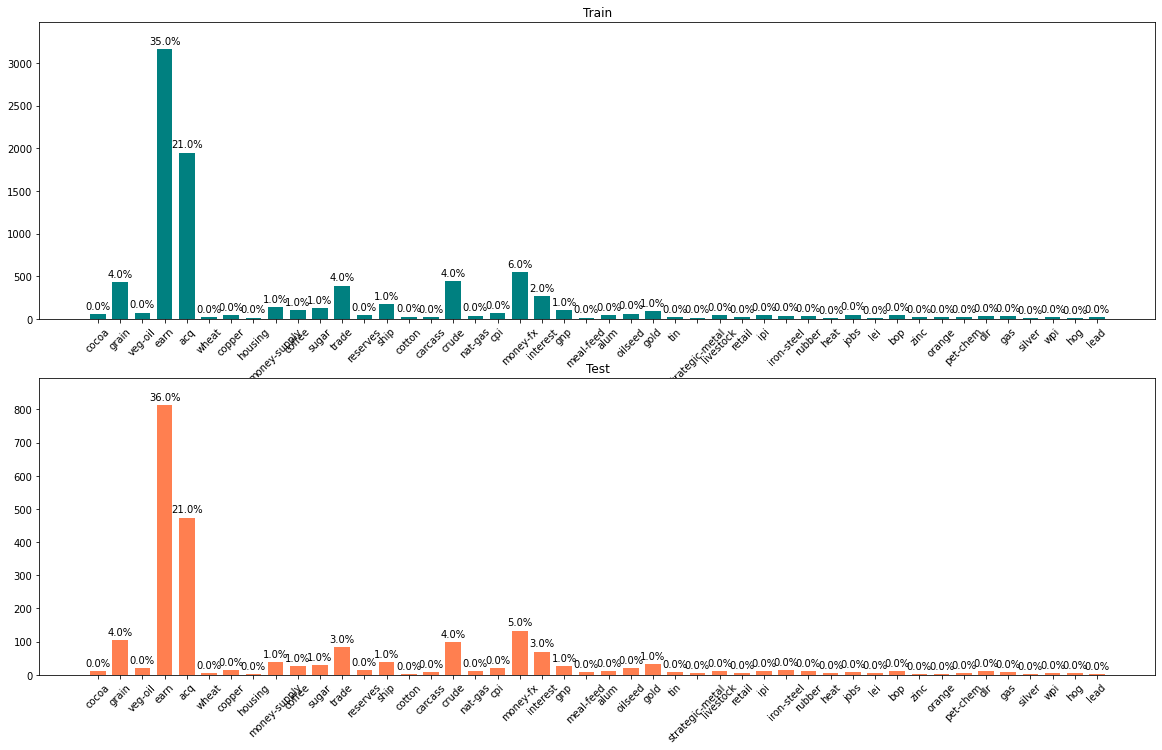

In [14]:
plot_distribution(train_labels, test_labels, params.classes)

![image-20201217123826241](images/image-20201217123826241.png)

### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

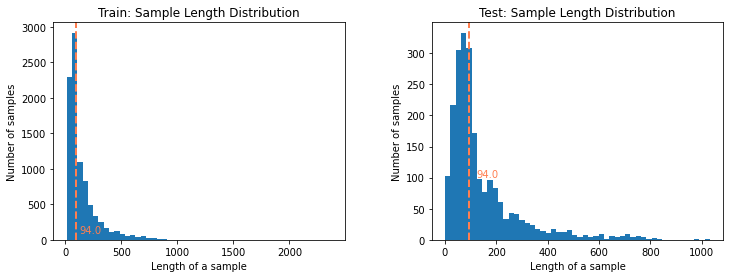

train：mean=144.54 variance=21261.74
test：mean=146.66 variance=21351.99


In [15]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))

![image-20210101163434402](images/image-20210101163434402.png)

通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [16]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,1211,550,225,99,70,30,27,25,9,2246
train,4834,2273,883,410,223,151,101,62,45,8982
合计,6045,2823,1108,509,293,181,128,87,54,11228


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,1209.215354,564.70057,221.639473,101.818133,58.610438,36.206448,25.60456,17.403099,10.801924,2246.0
train,4835.784646,2258.29943,886.360527,407.181867,234.389562,144.793552,102.39544,69.596901,43.198076,8982.0
合计,6045.000000,2823.00000,1108.000000,509.000000,293.000000,181.000000,128.00000,87.000000,54.000000,11228.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [17]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 9.355859347084184
critical_value = 15.50731305586545
p_value = 0.313170934470006


![image-20210101174317709](images/image-20210101174317709.png)

### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

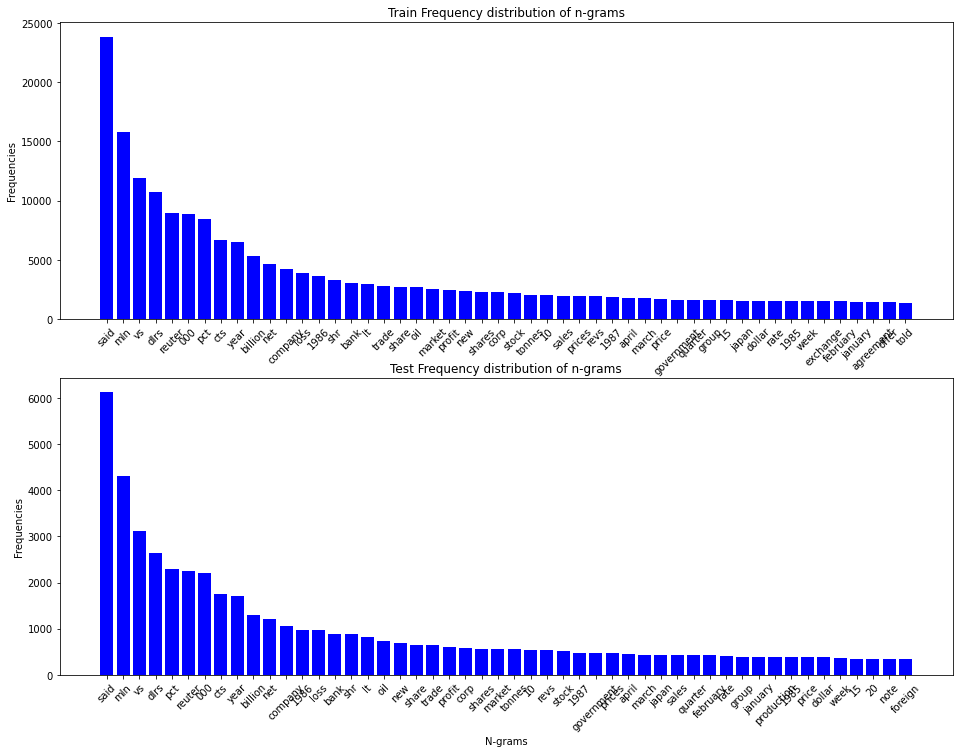

In [18]:
plot_frequency_distribution(train_texts, test_texts)

![image-20201217134151280](images/image-20201217134151280.png)

In [19]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 30978
Number of Vocabulary: 4676


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [20]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 95.6


![image-20201217144321430](images/image-20201217144321430.png)

可以看到这个比例大大小于143.7，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下两个过程。

- Tokenization：把文本转化成Token
- Vectorization： 把Token变成Vector

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [21]:
train_ngram, test_ngram, token_vectorizer = ngram_vectorize(train_texts, train_labels, test_texts, 
                                                            top_k=params.max_features)

print(train_ngram.shape, type(train_ngram), train_ngram.dtype)
print(test_ngram.shape, type(test_ngram), test_ngram.dtype)
print(train_ngram[0, 0:1000])

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:1799: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  UserWarning)


(8982, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
(2246, 20000) <class 'scipy.sparse.csr.csr_matrix'> float32
  (0, 89)	0.04556229
  (0, 103)	0.07045783
  (0, 153)	0.05212957
  (0, 227)	0.04881364
  (0, 280)	0.061424796
  (0, 336)	0.080923684
  (0, 372)	0.0749374
  (0, 378)	0.04922878
  (0, 453)	0.06102963
  (0, 534)	0.050600253
  (0, 647)	0.05339139
  (0, 973)	0.06349281
  (0, 974)	0.07553516


![image-20210102091446193](images/image-20210102091446193.png)

可以看到上面数据是以稀疏矩阵的形式存在的。下面创建ngram数据集。

In [22]:
ngram_data = SimpleTextDataset(params, train_ngram, train_labels, test_ngram, test_labels, train_texts, test_texts)

create train, validation and test dataset


### Sequence

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。下面将采用两种方式生成Sequence向量。

- Tokenizer
- TextVectorization

#### Tokenizer

In [23]:
train_seq, test_seq, tokenizer_seq = sequence_vectorize(train_texts, test_texts, 
                                                        top_k=params.max_features,
                                                        max_sequence_length =params.sequence_length
                                                       )

print(train_seq.shape, type(train_seq), train_seq.dtype)
print(test_seq.shape, type(test_seq), test_seq.dtype)
print(test_seq[0][0:500])

(8982, 500) <class 'numpy.ndarray'> int32
(2246, 500) <class 'numpy.ndarray'> int32
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

![image-20210102105418015](images/image-20210102105418015.png)

创建sequence数据集。

In [24]:
sequence_data = SequenceTextDataset(params, train_seq, train_labels, test_seq, test_labels, 
                                    train_texts, test_texts, tokenizer_seq)

create train, validation and test dataset




##  模型

### MLP

In [25]:
def sparse_to_dense(value):
    if isinstance(value, tf.sparse.SparseTensor):
        return tf.sparse.to_dense(value)
    return value

def get_mlp(helper, dropout=None, name='mlp'):
    """Creates an instance of a multi-layer perceptron model"""
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    layer_count = helper.get_model_param(name, 'layer_count')
    units = helper.get_model_param(name, 'units')    
    
    input = layers.Input(shape=helper.data.input_shape)    
    x = tf.keras.layers.Lambda(sparse_to_dense)(input)
    if dropout>0: x = layers.Dropout(dropout)(x)
        
    for _ in range(layer_count):
        x = layers.Dense(units, activation='relu')(x)
        if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    
    model = Model(inputs=input, outputs=x, name=name)     
    helper.compile(model)   
    return model

helper = TextClassificationHelper(params, model_results=model_results, data=ngram_data)
model = get_mlp(helper)
model.summary()

model_params.mlp.dropout=0.6
model_params.mlp.layer_count=1
model_params.mlp.units=256
learning_rate=0.001
checkpoint_path=./checkpoints/reuters/mlp/checkpoint
Model: "mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20000)]           0         
_________________________________________________________________
lambda (Lambda)              (None, 20000)             0         
_________________________________________________________________
dropout (Dropout)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               5120256   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None,

2021-01-05 08:52:40,418: INFO: start training


model_params.mlp.epochs=120
use ModelCheckpoint(filepath=./checkpoints/reuters/mlp/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/120
281/281 [==============================] - 1s 5ms/step - loss: 2.0940 - accuracy: 0.5461 - val_loss: 1.4376 - val_accuracy: 0.6647
Epoch 2/120
281/281 [==============================] - 1s 4ms/step - loss: 1.2805 - accuracy: 0.7001 - val_loss: 1.1325 - val_accuracy: 0.7440
Epoch 3/120
281/281 [==============================] - 1s 4ms/step - loss: 1.0302 - accuracy: 0.7643 - val_loss: 0.9757 - val_accuracy: 0.7769
Epoch 4/120
281/281 [==============================] - 1s 4ms/step - loss: 0.8785 - accuracy: 0.7976 - val_loss: 0.8821 - val_accuracy: 0.7907
Epoch 5/120
281/281 [==============================] - 1s 4ms/step - loss: 0.7687 - accuracy: 0.8213 - val_loss: 0.8165 - val_accuracy: 0.8059
Epoch 

281/281 [==============================] - 1s 4ms/step - loss: 0.2288 - accuracy: 0.9294 - val_loss: 0.8984 - val_accuracy: 0.8175
Epoch 00046: Still keep learning rate 0.0001 instead of 0.001
Epoch 46/120
281/281 [==============================] - 1s 4ms/step - loss: 0.2271 - accuracy: 0.9330 - val_loss: 0.8992 - val_accuracy: 0.8179
Epoch 00047: Still keep learning rate 0.0001 instead of 0.001
Epoch 47/120
281/281 [==============================] - 1s 4ms/step - loss: 0.2223 - accuracy: 0.9341 - val_loss: 0.9001 - val_accuracy: 0.8183
Epoch 00048: Still keep learning rate 0.0001 instead of 0.001
Epoch 48/120
281/281 [==============================] - 1s 4ms/step - loss: 0.2309 - accuracy: 0.9300 - val_loss: 0.9017 - val_accuracy: 0.8197
Epoch 00049: Still keep learning rate 0.0001 instead of 0.001
Epoch 49/120
281/281 [==============================] - 1s 4ms/step - loss: 0.2209 - accuracy: 0.9354 - val_loss: 0.9037 - val_accuracy: 0.8192
Epoch 00050: Still keep learning rate 0.0001 

2021-01-05 08:53:42,844: INFO: finish training [elapsed time: 62.43 seconds]


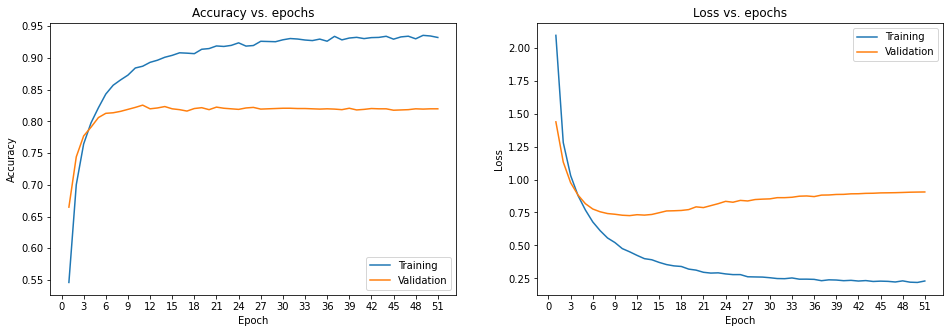

In [26]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
71/71 [==============================] - 0s 2ms/step - loss: 0.7260 - accuracy: 0.8255
Test loss:0.7260, Test Accuracy:82.55%
---------------------------------------- confusion matrix ----------------------------------------
71/71 [==============================] - 0s 2ms/step


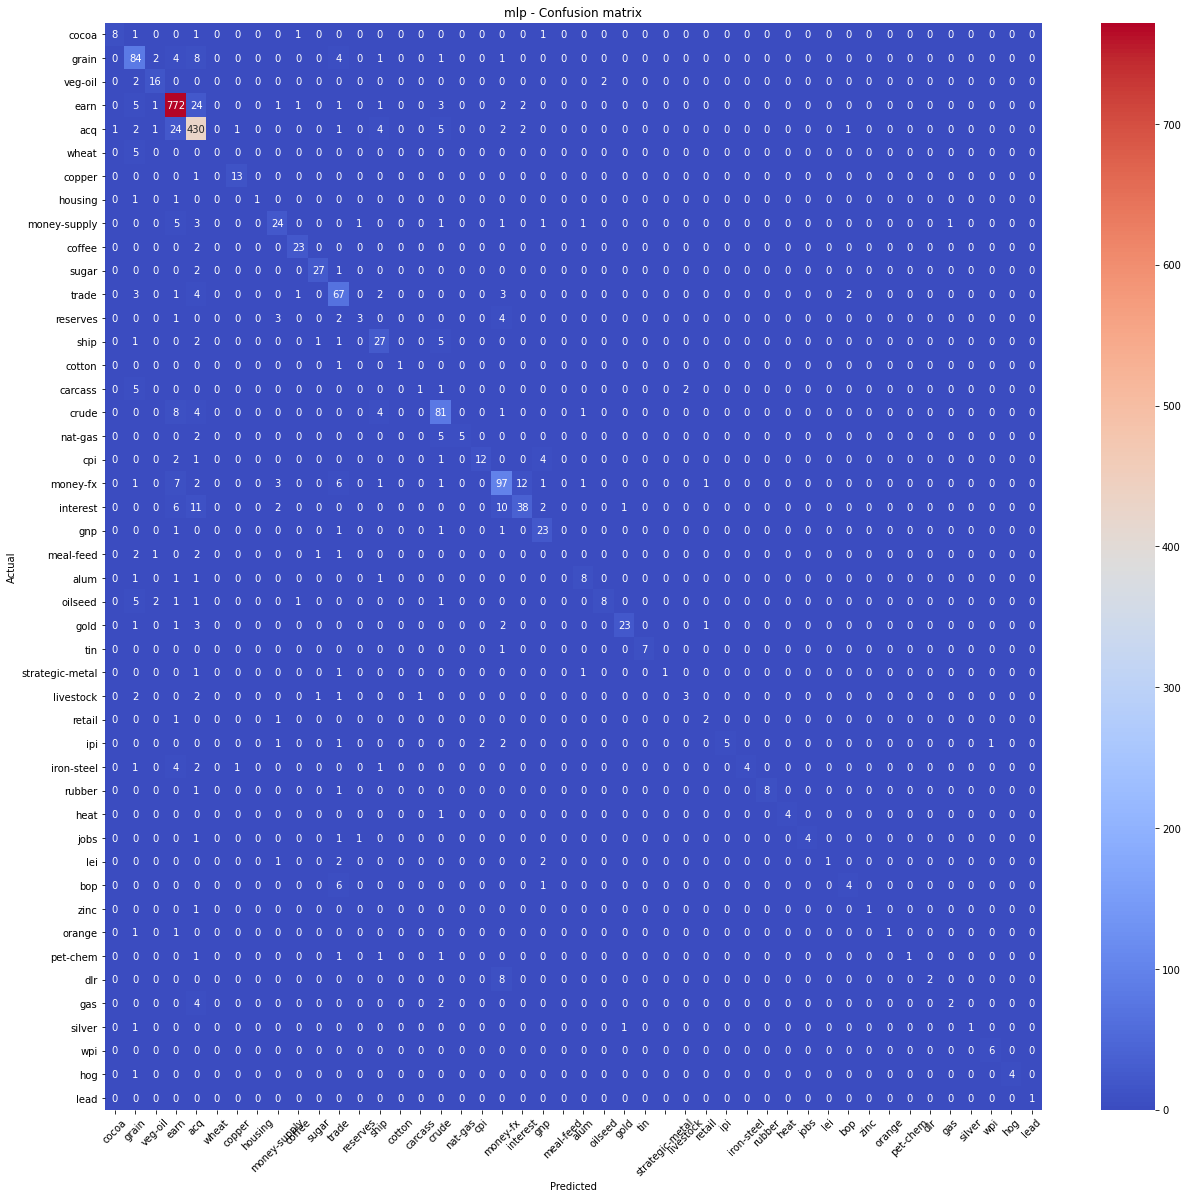

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.284494,0.9331,0.726025,0.8255,5132078,62.0


In [27]:
helper.model_summary(model, history=history)

### Embedding

In [28]:
def get_embedding(helper,
                 embedding_dim=None,
                 dropout=None,
                 name='embedding'
                ):

    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
    if embedding_dim is None:
        embedding_dim = helper.get_model_param(name, 'embedding_dim')        
        
    input_shape = helper.data.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)
    model.add(layers.Embedding(input_dim=num_features,
                               output_dim=embedding_dim,
                               input_length=input_shape[0]))
    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(num_classes))
    helper.compile(model)  
    return model


helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_embedding(helper)
model.summary()

model_params.embedding.dropout=0.4
model_params.embedding.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/reuters/embedding/checkpoint
Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 200)          4000200   
_________________________________________________________________
global_average_pooling1d (Gl (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 46)                9246      
Total params: 4,009,446
Trainable params: 4,009,446
Non-trainable params: 0
_________________________________________________________________


2021-01-05 08:53:57,517: INFO: start training


model_params.embedding.epochs=120
use ModelCheckpoint(filepath=./checkpoints/reuters/embedding/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/120
280/280 [==============================] - 6s 23ms/step - loss: 2.6058 - accuracy: 0.3512 - val_loss: 2.2570 - val_accuracy: 0.3798
Epoch 2/120
280/280 [==============================] - 6s 21ms/step - loss: 2.1644 - accuracy: 0.4013 - val_loss: 2.0654 - val_accuracy: 0.4439
Epoch 3/120
280/280 [==============================] - 6s 22ms/step - loss: 1.9740 - accuracy: 0.4921 - val_loss: 1.9019 - val_accuracy: 0.5338
Epoch 4/120
280/280 [==============================] - 6s 22ms/step - loss: 1.8156 - accuracy: 0.5592 - val_loss: 1.7671 - val_accuracy: 0.5895
Epoch 5/120
280/280 [==============================] - 6s 22ms/step - loss: 1.6741 - accuracy: 0.6038 - val_loss: 1.6564 - val_accura

280/280 [==============================] - ETA: 0s - loss: 0.1954 - accuracy: 0.9491
Epoch 00055: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
280/280 [==============================] - 6s 21ms/step - loss: 0.1954 - accuracy: 0.9491 - val_loss: 0.9551 - val_accuracy: 0.8077
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
Epoch 56/120
280/280 [==============================] - 6s 21ms/step - loss: 0.1857 - accuracy: 0.9528 - val_loss: 0.9562 - val_accuracy: 0.8094
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
Epoch 57/120
280/280 [==============================] - 6s 21ms/step - loss: 0.1800 - accuracy: 0.9522 - val_loss: 0.9580 - val_accuracy: 0.8103
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/120
280/280 [==============================] - 6s 21ms/step - loss: 0.1790 - accuracy: 0.9537 - val_loss: 0.9596 - val_accuracy: 0.8077
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
Epoch 5

2021-01-05 09:02:04,103: INFO: finish training [elapsed time: 486.59 seconds]


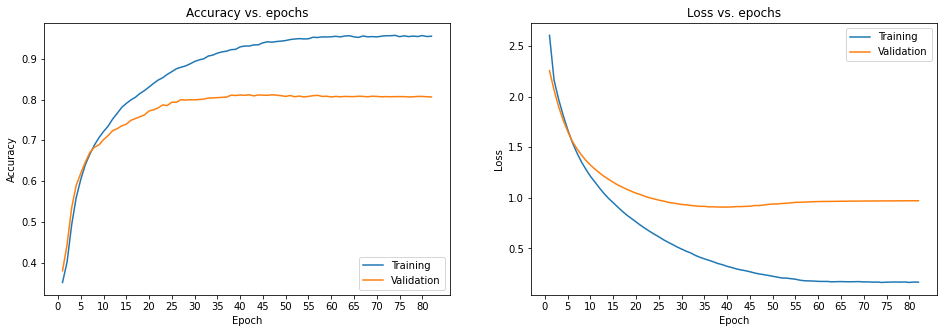

In [29]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
71/71 [==============================] - 0s 3ms/step - loss: 0.9134 - accuracy: 0.8117
Test loss:0.9134, Test Accuracy:81.17%
---------------------------------------- confusion matrix ----------------------------------------
71/71 [==============================] - 0s 3ms/step


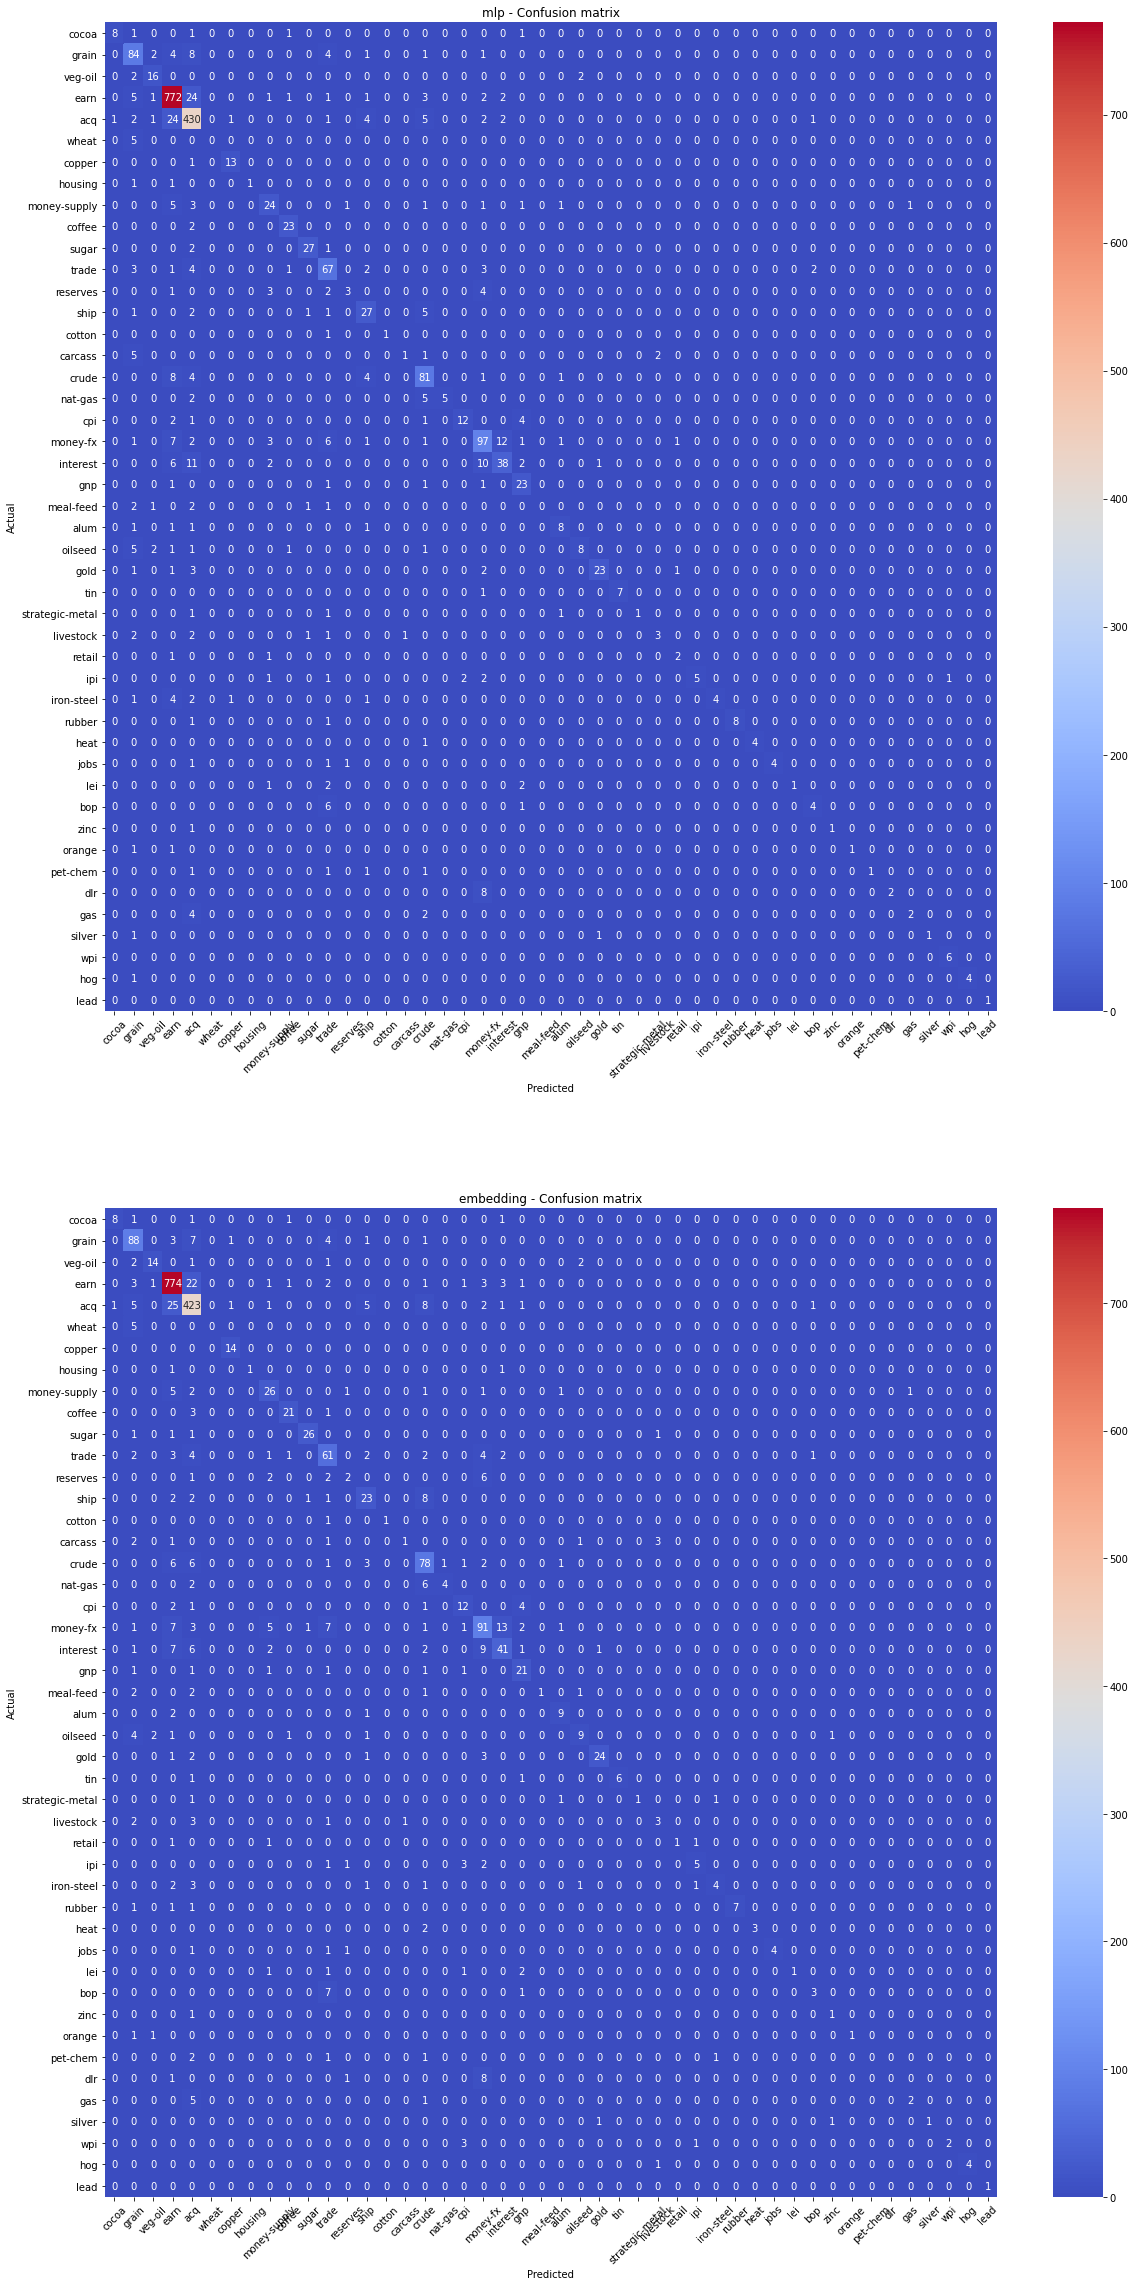

---------------------------------------- error analysis ----------------------------------------
71/71 [==============================] - 0s 3ms/step
........................................ sugar ........................................
intergrated generics inc said its biopharmaceutics inc subsidiary is in negotiations with a manufacturer and distributor of generic equivalents of brand name prescription drugs the company said a successful agreement would allow it to distribute chlorazepate dipotasssium an anti anxiety drug with a market potential of 80 mln dlrs integrated said the licensor has asked for anonymity at this time finalization of the agreement is expected within two or three weeks the company said reuter 3


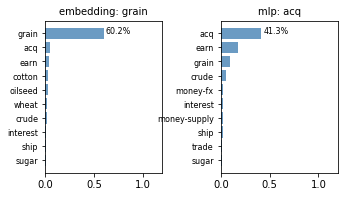

........................................ bop ........................................
treasurer paul keating said he now expected the australian current account deficit for fiscal 1986 87 ending june 30 to come in around 13 25 billion dlrs in a statement released after statistics bureau figures showed the may deficit was below forecasts at 866 mln dlrs keating said the cumulative deficit is now likely to be about 1 5 billion dlrs below the treasury forecast of 14 75 billion issued with the 1986 87 budget papers last august however the government had subsequently revised the forecast to around 13 75 billion dlrs after a series of current account figures indicated a declining trend keating's revised 1986 87 current account deficit forecast compares with a record shortfall of 14 40 billion dlrs in 1985 86 a level nearly double the 7 29 billion deficit recorded only two years earlier in 1983 84 keating said the main reason for his revision was a better than expected export performance rece

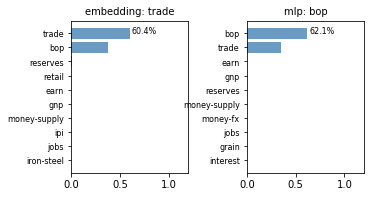

........................................ trade ........................................
summit petroleum corp said it sold 11 3 mln shares or 29 4 pct of its common stock to lt halbert and associates inc the company said the shares were previously held by lt consolidated energy corp and harken oil and gas inc lt hogi in addition david d halbert president and chief executive officer of halbert an abilene investment firm was named chairman and chief executive of summit the company said halbert charles m bruce and james o burke were also named directors expanding the board to five summit added the company said burke is president and chief executive of lt allied comprehensive health inc abilene while bruce is a partner in the washington law firm of butler and binion summit said it intends to actively seek acquisitions to increase its asset base reuter 3


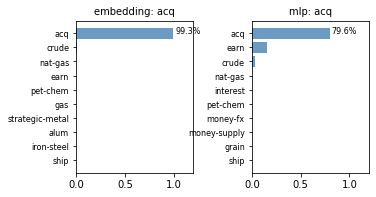

........................................ money-fx ........................................
the bank of japan has become increasingly worried about a possible crash of high flying financial markets bank of japan sources said we're afraid that someday the bubble will burst and that the deflationary impact on the economy will be very disastrous one source said they said the central bank has embarked on a delicate policy it wants to deflate the speculation that has pumped up prices sharply in recent months without bursting the bubble stock prices plunged 393 31 points today extending the sharp declines of earlier this month as the market speculated that interest rates would rise the bank of japan bought 100 billion yen in certificates of deposit cds via repurchase agreements today to show its determination to maintain an easy money policy central bank officials said today's cd buying operation was designed to reassure the market the bank has not changed its policy a senior central bank off

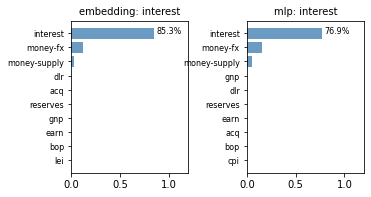

........................................ acq ........................................
three london markets which trade potato soymeal and meat futures said they will merge to form a new agricultural futures exchange legal advisers have been instructed to implement the amalgamation of the london potato futures association lpfa the london meat futures exchange lmfe and the grain and feed trade association's gafta soya bean meal futures association somfa no timetable was given members of the three exchanges have been consulted agricultural futures exchange secretary bill englebright told reuters and no objections have been raised to the merger three markets are involved at present but the new exchange could ultimately combine five markets discussions are taking place with the baltic international freight futures exchange biffex and the gafta london grain futures market is considering the possibility of joining the other markets market officials said the biffex board is expected to reach a

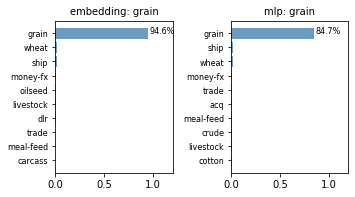

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.284494,0.9331,0.726025,0.8255,5132078,62.0
embedding,0.273069,0.9387,0.913398,0.8117,4009446,486.0


In [30]:
helper.model_summary(model, history=history)

### sepCNN

In [31]:
def get_sepcnn(helper,
                 blocks=1,
                 filters=64,
                 kernel_size=3,
                 embedding_dim=200,
                 dropout=None,
                 pool_size=3,
                 use_pretrained_embedding=False,
                 is_embedding_trainable=False,
                 embedding_matrix=None, 
                 name='sepcnn'
                ):
    """Creates an instance of a separable CNN model.

    # Arguments
        blocks: int, number of pairs of sepCNN and pooling blocks in the model.
        filters: int, output dimension of the layers.
        kernel_size: int, length of the convolution window.
        embedding_dim: int, dimension of the embedding vectors.
        dropout: float, percentage of input to drop at Dropout layers.
        pool_size: int, factor by which to downscale input at MaxPooling layer.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.
        num_features: int, number of words (embedding input dimension).
        use_pretrained_embedding: bool, true if pre-trained embedding is on.
        is_embedding_trainable: bool, true if embedding layer is trainable.
        embedding_matrix: dict, dictionary with embedding coefficients.

    # Returns
        A sepCNN model instance.
    """
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')
        
    input_shape = helper.data.input_shape
    num_classes = len(helper.params.classes)
    num_features = helper.params.max_features+1  
    
    model = models.Sequential(name=name)

    # Add embedding layer. If pre-trained embedding is used add weights to the
    # embeddings layer and set trainable to input is_embedding_trainable flag.
    if use_pretrained_embedding:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0],
                                   weights=[embedding_matrix],
                                   trainable=is_embedding_trainable))
    else:
        model.add(layers.Embedding(input_dim=num_features,
                                   output_dim=embedding_dim,
                                   input_length=input_shape[0]))

    for i in range(blocks):
        model.add(layers.Dropout(rate=dropout))
        if i==blocks-1: filters=filters*2
        model.add(layers.SeparableConv1D(filters=filters,
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.SeparableConv1D(filters=filters,     
                                         kernel_size=kernel_size,
                                         activation='relu',
                                         bias_initializer='random_uniform',
                                         depthwise_initializer='random_uniform',
                                         padding='same'))
        model.add(layers.MaxPooling1D(pool_size=pool_size))

    model.add(layers.GlobalAveragePooling1D())
    if dropout>0: model.add(layers.Dropout(rate=dropout))
    model.add(layers.Dense(num_classes))
    helper.compile(model)  
    return model


helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_sepcnn(helper, blocks=1)
# when bolcks=2, the model can't converg
model.summary()

model_params.sepcnn.dropout=0.4
learning_rate=0.001
checkpoint_path=./checkpoints/reuters/sepcnn/checkpoint
Model: "sepcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
dropout_3 (Dropout)          (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 500, 128)          26328     
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 500, 128)          16896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 166, 128)          0         
_________________________________________________________________
global_average_pooling1d_1 ( (None, 128)               0         
__________________

2021-01-05 09:02:37,660: INFO: start training


model_params.sepcnn.epochs=40
use ModelCheckpoint(filepath=./checkpoints/reuters/sepcnn/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/40
280/280 [==============================] - 7s 27ms/step - loss: 2.6082 - accuracy: 0.3318 - val_loss: 2.1460 - val_accuracy: 0.3887
Epoch 2/40
280/280 [==============================] - 7s 26ms/step - loss: 1.9646 - accuracy: 0.4342 - val_loss: 1.8400 - val_accuracy: 0.5321
Epoch 3/40
280/280 [==============================] - 7s 26ms/step - loss: 1.7798 - accuracy: 0.5530 - val_loss: 1.7217 - val_accuracy: 0.5757
Epoch 4/40
280/280 [==============================] - 7s 26ms/step - loss: 1.6299 - accuracy: 0.5949 - val_loss: 1.6502 - val_accuracy: 0.5935
Epoch 5/40
280/280 [==============================] - 7s 26ms/step - loss: 1.5403 - accuracy: 0.6146 - val_loss: 1.6197 - val_accuracy: 0.6006
E

2021-01-05 09:07:30,517: INFO: finish training [elapsed time: 292.86 seconds]


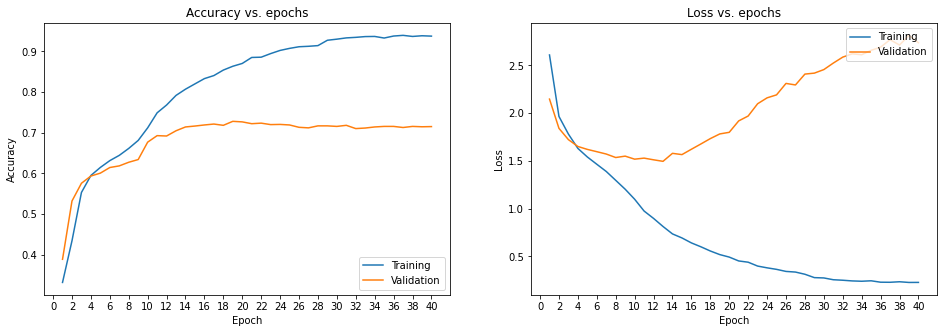

In [32]:
history = helper.train(model, batch_size=32)

---------------------------------------- evaluate ----------------------------------------
71/71 [==============================] - 0s 5ms/step - loss: 1.7816 - accuracy: 0.7280
Test loss:1.7816, Test Accuracy:72.80%
---------------------------------------- confusion matrix ----------------------------------------
71/71 [==============================] - 0s 4ms/step


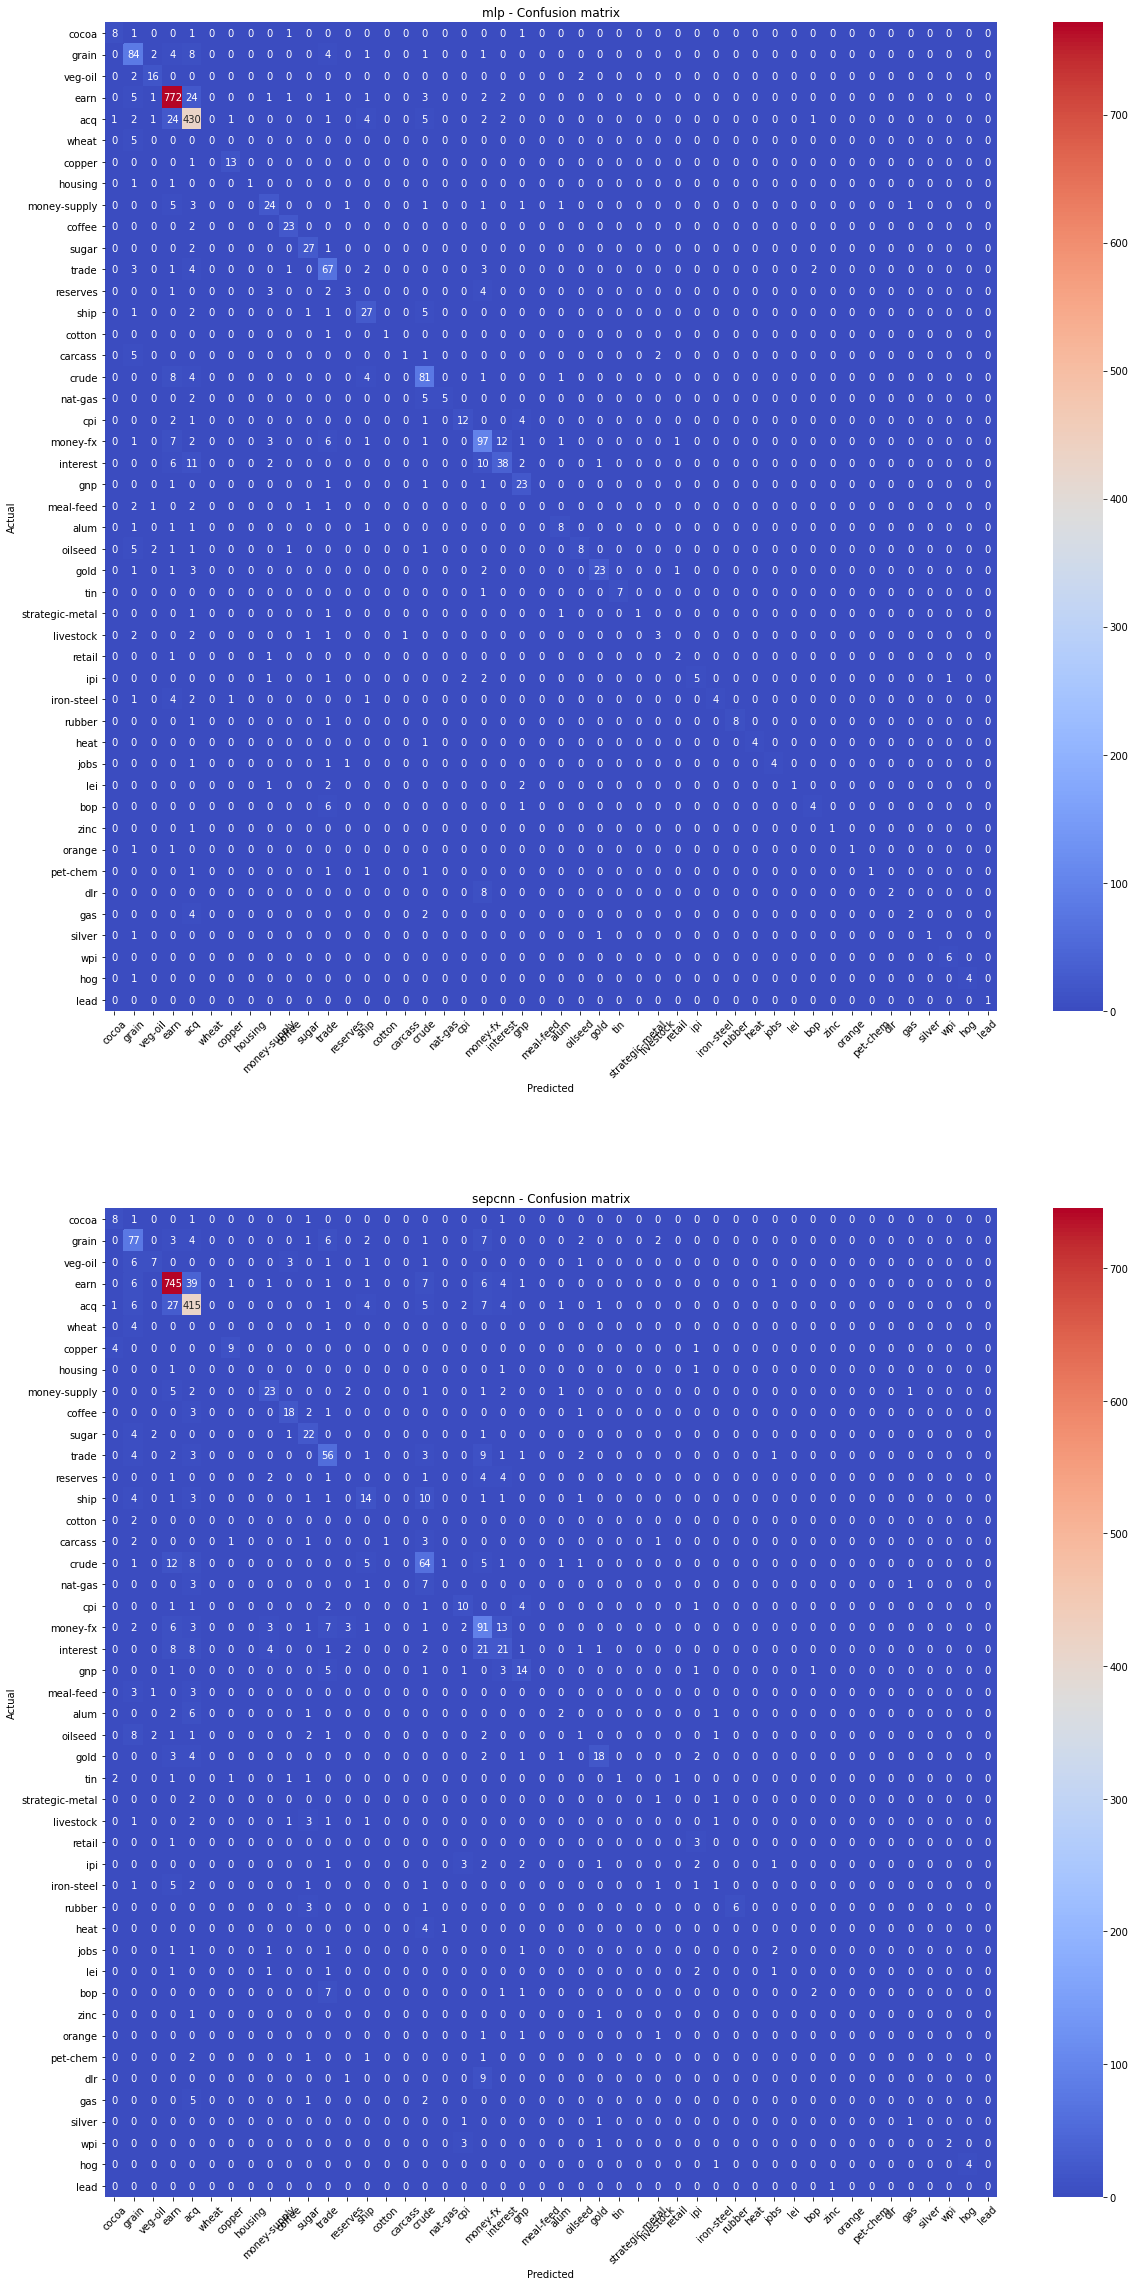

---------------------------------------- error analysis ----------------------------------------
71/71 [==============================] - 0s 4ms/step
........................................ interest ........................................
the world bank's policies prevent it from lending money for the transfer of land from landowners to the landless but it can help finance development of the philippines' proposed land reform program a bank official said the world bank by its established policies cannot use its resources to finance the transfer of assets from one group to another our mandate is to finance investment related activities rolando arrivillaga the bank's resident representative in the philippines told reuters in an interview arrivillaga said he wanted to clarify part of a report by a world bank mission that came in march to review the land reform program and which said the bank would not be able to finance compensation payments for the transfer of land he said the philippin

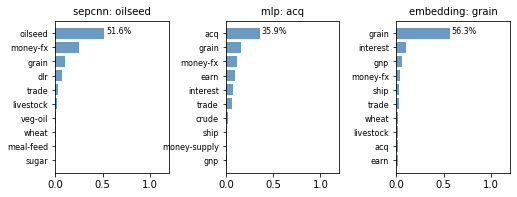

........................................ acq ........................................
brazil is not happy with the existing structure of the 14 bank advisory committee which coordinates its commercial bank debt finance minister dilson funaro said u s banks have 50 pct representation on the committee while holding only 35 pct of brazil's debt to banks he said adding this is not fair with the european and japanese banks the committee had played a useful role in 1982 and 1983 however noting the often different reactions of u s japanese and european banks funaro told journalists that brazil might adopt an approach involving separate discussions with the regions since debtor nations' problems were normally treated on a case by case basis perhaps the same principle should apply to creditors central bank president francisco gros said brazil on february 20 suspended indefinitely interest payments on 68 billion dlrs owed to commercial banks followed last week by a freeze on bank and trade credi

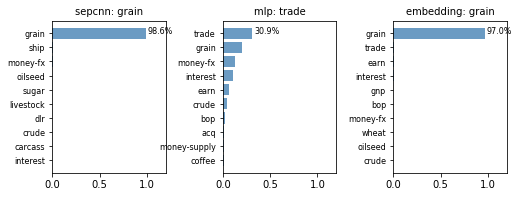

........................................ earn ........................................
the u s agriculture department forecast australia's 1986 87 wheat crop at 16 70 mln tonnes vs 17 30 mln tonnes last month it estimated 1985 86 output at 16 13 mln tonnes vs 16 13 mln last month australian wheat exports in 1986 87 are forecast at 14 50 mln tonnes vs 14 50 mln tonnes last month while exports in 1985 86 are estimated at 15 96 mln tonnes vs 15 96 mln last month reuter 3


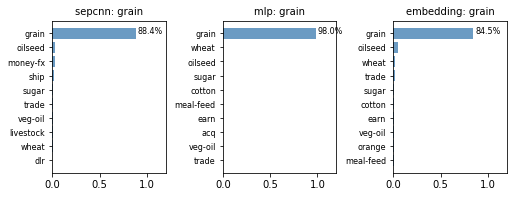

........................................ interest ........................................
the bundesbank is unlikely to change credit policies when its central bank council meets on thursday for its last session before the venice summit banking economists and money market dealers said the bundesbank steered money market rates lower last month by cutting the rate on its security repurchase pacts and is unlikely to cap this move with a cut in leading interest rates in the near future they said the council will meet in saarbruecken and the meeting will be followed by a news conference at around 1030 gmt but bundesbank officials noted that a news conference was usually called when the council meets outside frankfurt and did not necessarily herald any policy moves bundesbank vice president helmut schlesinger said today there was no reason to cut interest rates because money supply growth had shown no signs of slowing in may and the dollar was stable against the mark schlesinger told reuter

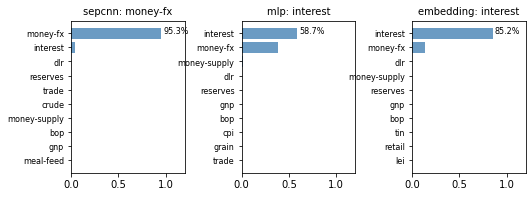

........................................ ship ........................................
brazil's labour unrest is spreading with many banks universities and government statistical offices on strike and more pay disputes looming bankworkers' leaders said that a national strike launched yesterday to press for a 100 pct immediate pay rise and monthly salary adjustments had the support of most of the 700 000 workforce the strike today closed the stock exchanges of sao paulo and rio de janeiro for the government the one positive development on the labour front was the gradual return to work of the nation's 40 000 seamen who began a national strike on february 27 a union spokesman in rio de janeiro told reuters about half the seamen had returned to work after accords with 22 companies and that the strike looked close to an end otherwise the labour scene looked bleak with the bank strike posing the most serious problems for brazil's crisis laden economy if this goes on for more than a few days

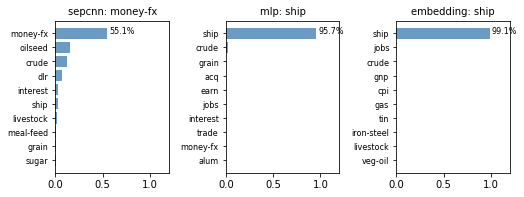

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.284494,0.9331,0.726025,0.8255,5132078,62.0
embedding,0.273069,0.9387,0.913398,0.8117,4009446,486.0
sepcnn,0.350979,0.9067,1.781556,0.7280,4049358,292.0


In [33]:
helper.model_summary(model, history=history)

### LSTM

In [34]:
def get_lstm(helper, name='rnn_lstm', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   

    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm(helper)
model.summary()


model_params.rnn_lstm.dropout=0.3
model_params.rnn_lstm.units=200
max_features=20000
model_params.rnn_lstm.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/reuters/rnn_lstm/checkpoint
Model: "rnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
lstm (LSTM)                  (None, 200)               320800    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 46)                9246      
Total params: 4,330,246
Trainable params: 4,330,246
N

2021-01-05 09:08:05,985: INFO: start training


model_params.rnn_lstm.epochs=20
use ModelCheckpoint(filepath=./checkpoints/reuters/rnn_lstm/checkpoint, monitor=val_accuracy)
use EarlyStopping(monitor=val_accuracy, patience=40)
use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
use LearningRateScheduler()
Epoch 1/20
280/280 [==============================] - 159s 567ms/step - loss: 2.1982 - accuracy: 0.4427 - val_loss: 2.2470 - val_accuracy: 0.4074
Epoch 2/20
280/280 [==============================] - 158s 563ms/step - loss: 2.0191 - accuracy: 0.4485 - val_loss: 1.8619 - val_accuracy: 0.5419
Epoch 3/20
280/280 [==============================] - 158s 565ms/step - loss: 1.7261 - accuracy: 0.5506 - val_loss: 1.7557 - val_accuracy: 0.5503
Epoch 4/20
280/280 [==============================] - 157s 562ms/step - loss: 1.5134 - accuracy: 0.6020 - val_loss: 1.6016 - val_accuracy: 0.6051
Epoch 5/20
280/280 [==============================] - 157s 561ms/step - loss: 1.3757 - accuracy: 0.6384 - val_loss: 1.5694 - val

2021-01-05 10:00:48,410: INFO: finish training [elapsed time: 3162.43 seconds]


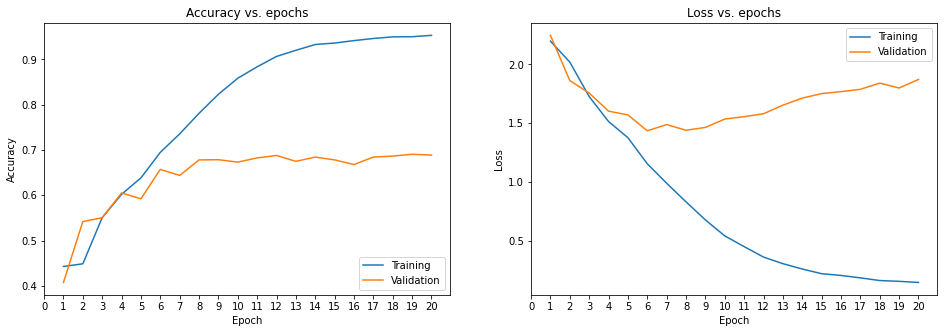

In [35]:
history = helper.train(model)

---------------------------------------- evaluate ----------------------------------------
71/71 [==============================] - 11s 149ms/step - loss: 1.7986 - accuracy: 0.6906
Test loss:1.7986, Test Accuracy:69.06%
---------------------------------------- confusion matrix ----------------------------------------
71/71 [==============================] - 10s 148ms/step


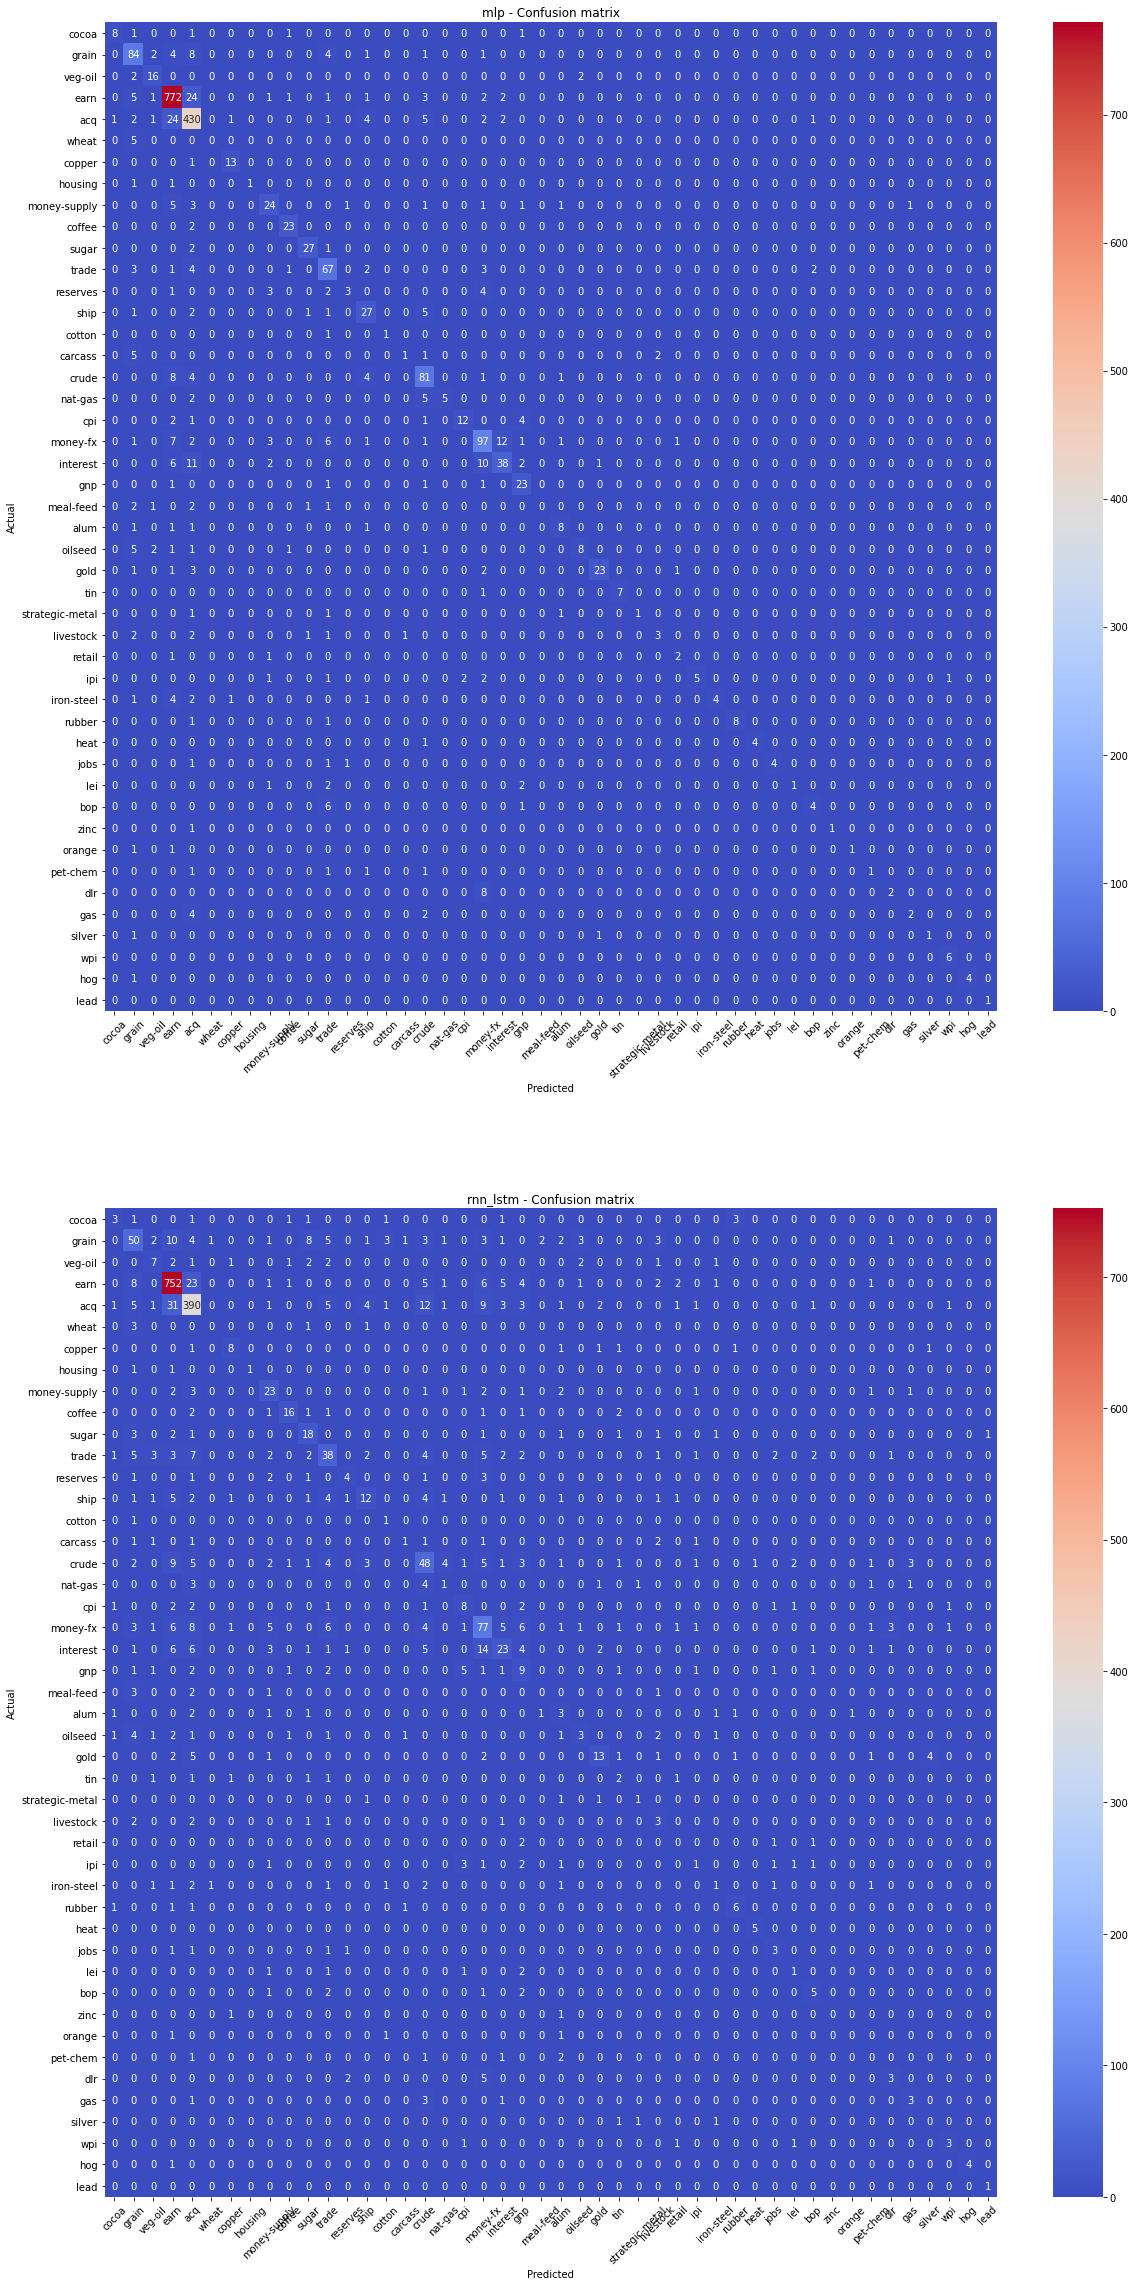

---------------------------------------- error analysis ----------------------------------------
71/71 [==============================] - 9s 120ms/step
........................................ gnp ........................................
brazil's gross domestic product gdp rose by 8 2 pct in real terms last year following an 8 3 pct increase in 1985 the geography and statistics institute said in money terms this equalled 3 6 trillion cruzados giving per capita gdp of 26 120 cruzados or 1 6 pct above the level achieved in 1980 before the recession of 1981 1983 the institute said in a statement agricultural output hit by adverse weather fell by 7 3 pct last year led by coffee production which was 46 pct down industry grew 12 1 pct including capital goods by 21 6 pct and consumer goods by 20 3 pct while services were up 8 3 pct reuter 3


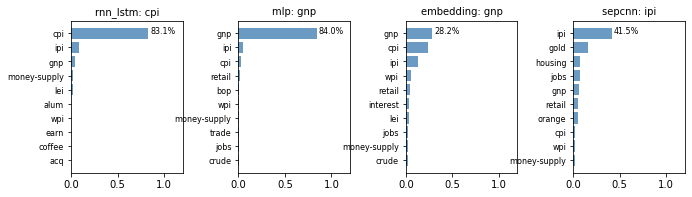

........................................ copper ........................................
lt teck corp said it was continuing talks about joining a joint copper venture at highland valley british columbia held by affiliates cominco ltd lt clt and lt lornex mining corp but did not know when negotiations would be completed teck vice president of administration john guminski said in reply to a query that the talks had been ongoing for a long time he declined to speculate on the outcome cominco 29 5 pct owned by a consortium led by teck is optimistic that the talks will soon be concluded spokesman don townson told reuters i think all partners are hopeful that the situation will be resolved cominco's townson said we're optimistic that they will be concluded shortly he added townson declined to specify when the talks might end cominco and teck's 22 pct owned lornex agreed in january 1986 to form the joint venture merging their highland valley copper operations cominco and lornex share equally

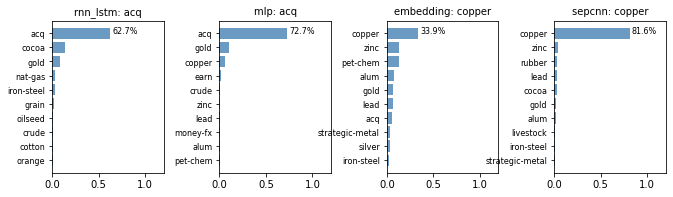

........................................ cpi ........................................
south africa is expected to unveil tomorrow an expansionary budget for the second consecutive year in a bid to boost the nation's flagging economic growth rate economic analysts said faced with competing demands for increased military and police spending and the pressing need for more funds for black housing and education finance minister barend du plessis is expected to raise significantly the government's overall expenditure targets when he presents the budget to parliament the analysts said analysts expect du plessis to provide for a rise in state spending at least equal to the 16 pct inflation rate for the financial year that started on april 1 while ignoring pleas from the private sector to stimulate growth by cutting taxes fiscal policy has become gradually more expansionary but simply raising government spending and increasing the budget deficit is an inflationary form of stimulation said rob l

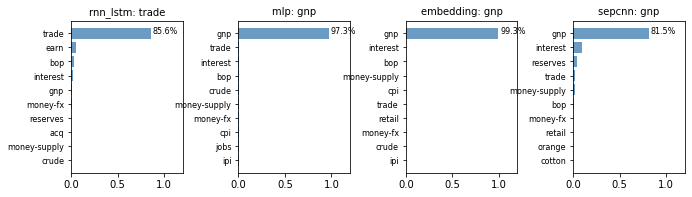

........................................ dlr ........................................
egypt's central bak left the dollar rate for commercial banks for april 8 unchanged at 1 353 67 pounds reuter 3


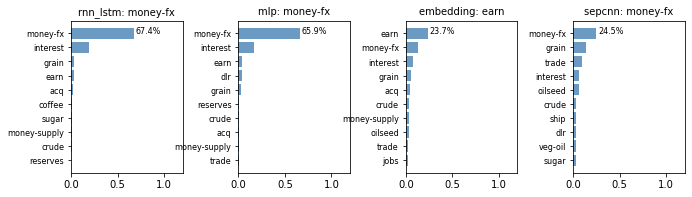

........................................ strategic-metal ........................................
japan's agency of natural resources and energy said it will begin experiments with thailand at the end of march to start commercial production of rare metals in 1989 under a joint project an agency official said it will set up a 500 mln yen pilot plant in bangkok which will extract high quality rare metals such as titanium and niobium from sand left over from tin production processes in thailand the plant wilq use about a tonne of sand per day although it is unclear how much rare metal will be extracted the official said reuter 3


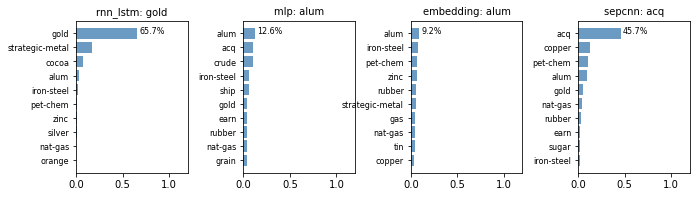

-------------------------------------------------- all models --------------------------------------------------


,train_loss,train_accuracy,test_loss,test_accuracy,weight_number,train_time
mlp,0.284494,0.9331,0.726025,0.8255,5132078,62.0
embedding,0.273069,0.9387,0.913398,0.8117,4009446,486.0
sepcnn,0.350979,0.9067,1.781556,0.7280,4049358,292.0
rnn_lstm,0.101330,0.9640,1.798558,0.6906,4330246,3162.0


In [36]:
helper.model_summary(model, history=history)

### LSTM + Bidirectional + Stacked

In [37]:
def get_lstm_stacked(helper, name='rnn_lstm_stacked', dropout=None):
    if dropout is None:
        dropout = helper.get_model_param(name, 'dropout')   
    
    units = helper.get_model_param(name, 'units')
    max_features = helper.get_model_param(name, 'max_features')
    embedding_dim = helper.get_model_param(name, 'embedding_dim') 
    
    input = layers.Input(shape=helper.data.input_shape)
    x = layers.Embedding(input_dim=max_features+1, output_dim=embedding_dim, mask_zero=True)(input)
    x = layers.Bidirectional(layers.LSTM(units=units, return_sequences=True))(x)
    x = layers.LSTM(units=units)(x)
    if dropout>0: x = layers.Dropout(dropout)(x)
    x = layers.Dense(len(helper.params.classes))(x)  
    model = Model(inputs=input, outputs=x, name=name) 
    helper.compile(model)      
    return model 

helper = TextClassificationHelper(params, model_results=model_results, data=sequence_data)
model = get_lstm_stacked(helper)
model.summary()

model_params.rnn_lstm_stacked.dropout=0.3
model_params.rnn_lstm_stacked.units=200
max_features=20000
model_params.rnn_lstm_stacked.embedding_dim=200
learning_rate=0.001
checkpoint_path=./checkpoints/reuters/rnn_lstm_stacked/checkpoint
Model: "rnn_lstm_stacked"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 500, 200)          4000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 400)          641600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_____________

In [38]:
# history = helper.train(model)

In [39]:
# helper.model_summary(model, history=history)

## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)